# Part 1
#### Import libraries

In [ ]:
import pytz
import torch
from PIL import Image
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.optim import SGD
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
from torch.utils.data import Dataset
import time
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
from torch.autograd import Variable
import numpy as np
from torch import optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile

zip_file = '/content/drive/MyDrive/Datasets/Finger Print ML-Dataset.zip'
extract_folder = '/content/'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Part 2
#### load train and test data

In [4]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
# Resize the images and transform to tensors
transformation = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor()
    ])

In [6]:
# Load the training dataset
train_folder_dataset = datasets.ImageFolder(root="Finger Print ML-Dataset/train/")

# Initialize the network
train_siamese_dataset = SiameseNetworkDataset(imageFolderDataset=train_folder_dataset,
                                        transform=transformation)

train_dataloader = DataLoader(train_siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
print(len(train_dataloader))

12


In [8]:
# Load the training dataset
test_folder_dataset = datasets.ImageFolder(root="Finger Print ML-Dataset/test/")

# Initialize the network
test_siamese_dataset = SiameseNetworkDataset(imageFolderDataset=test_folder_dataset,
                                        transform=transformation)

test_dataloader = DataLoader(test_siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

In [9]:
print(len(test_dataloader))

3


In [10]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

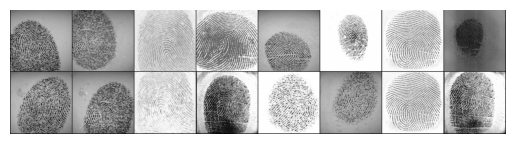

[0. 0. 0. 1. 1. 1. 0. 1.]


In [32]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(train_siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same finger, label is 0, same finger in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

# Part 3
#### Implementing CNN model

In [16]:
class SiameseModel(nn.Module):
    def __init__(self):
        super(SiameseModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=11, stride=1, padding=5)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU()
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.relu5 = nn.ReLU()
        self.fc1 = nn.Linear(2304, 1000)
        self.fc2 = nn.Linear(1000, 45)

    def forward_one(self, x):
        y = self.conv1(x)
        y = self.bn1(y)
        y = self.relu1(y)
        y = self.pool1(y)

        y = self.conv2(y)
        y = self.bn2(y)
        y = self.relu2(y)
        y = self.pool2(y)

        y = self.conv3(y)
        y = self.bn3(y)
        y = self.relu3(y)
        y = self.pool3(y)

        y = self.conv4(y)
        y = self.bn4(y)
        y = self.relu4(y)
        y = self.pool4(y)

        y = self.conv5(y)
        y = self.bn5(y)
        y = self.relu5(y)
        y = self.pool5(y)

        y = self.conv6(y)
        y = self.bn6(y)
        y = self.relu6(y)
        y = self.pool6(y)

        y = self.flatten(y)
        y = self.fc1(y)
        y = self.relu5(y)
        y = self.fc2(y)

        return y

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

In [17]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

# Part 4
#### Creating an object from the model and Implementation of optimizer and loss function

In [18]:
# CNNmodel
model = SiameseModel()

# loss function
criterion = ContrastiveLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SiameseModel(
  (conv1): Conv2d(3, 16, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4)

# Part 5
#### Train Time

In [20]:
train_losses = []
validation_losses = []
best_epoch_number = 0

def train(early_stopping_patience=50):
    global best_epoch_number

    best_loss = float('inf')
    current_patience = 0
    best_model_state = None
    num_epochs = 200
    # Training loop
    for epoch in range(1, num_epochs):
        start_time = time.time()
        _train_losses = []
        for i, (img0, img1, labels) in enumerate(train_dataloader, 0):

            # Send the images and labels to CUDA
            img0, img1, labels = img0.cuda(), img1.cuda(), labels.cuda()

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = model(img0, img1)

            # Pass the outputs of the networks and label into the loss function
            loss_contrastive = criterion(output1, output2, labels)

            # Calculate the backpropagation
            loss_contrastive.backward()

            _train_losses.append(loss_contrastive.item())

            optimizer.step()

        # Calculate validation loss
        _validation_losses = []
        with torch.no_grad():
            for i, (img0, img1, labels) in enumerate(test_dataloader, 0):
                val_img0, val_img1, val_labels = img0.to(device), img1.to(device), labels.to(device)
                # forward + backward + optimize
                val_outputs0, val_outputs1 = model(val_img0, val_img1)
                val_loss = criterion(val_outputs0, val_outputs1, val_labels)
                _validation_losses.append(val_loss.item())

        avg_validation_loss = sum(_validation_losses) / len(_validation_losses)
        validation_losses.append(avg_validation_loss)

        if avg_validation_loss < best_loss:
            best_loss = avg_validation_loss
            best_epoch_number = epoch
            best_model_state = model.state_dict()
            current_patience = 0
        else: # when the network loss goes up
            current_patience += 1


        avg_loss = sum(_train_losses) / len(_train_losses)
        train_losses.append(avg_loss)

        # print statistics
        end_time = time.time()
        elapsed_time = end_time - start_time
        if epoch < 10:
            print(f'Epoch [{epoch:.2f}/{num_epochs}], Train Loss: {avg_loss:.6f} Validation Loss: {avg_validation_loss:.6f}, distance to Best val epoch number: {epoch - best_epoch_number}, Elapsed_time: {elapsed_time:.5f}')
        elif epoch <= 99 and epoch < 100:
            print(f'Epoch [{epoch:.1f}/{num_epochs}], Train Loss: {avg_loss:.6f} Validation Loss: {avg_validation_loss:.6f}, distance to Best val epoch number: {epoch - best_epoch_number}, Elapsed_time: {elapsed_time:.5f}')
        else:
            print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {avg_loss:.6f} Validation Loss: {avg_validation_loss:.6f}, distance to Best val epoch number: {epoch - best_epoch_number}, Elapsed_time: {elapsed_time:.5f}')

        if current_patience >= early_stopping_patience:
            print("Early stopping triggered.")
            model.load_state_dict(best_model_state)
            break
    model.load_state_dict(best_model_state)
    print('Finished Training')

In [21]:
train()

Epoch [1.00/200], Train Loss: 0.612852 Validation Loss: 0.519740, distance to Best val epoch number: 0, Elapsed_time: 12.69222
Epoch [2.00/200], Train Loss: 0.436192 Validation Loss: 0.573224, distance to Best val epoch number: 1, Elapsed_time: 9.80484
Epoch [3.00/200], Train Loss: 0.342507 Validation Loss: 0.628414, distance to Best val epoch number: 2, Elapsed_time: 10.08535
Epoch [4.00/200], Train Loss: 0.359770 Validation Loss: 0.547781, distance to Best val epoch number: 3, Elapsed_time: 8.54347
Epoch [5.00/200], Train Loss: 0.303441 Validation Loss: 0.584261, distance to Best val epoch number: 4, Elapsed_time: 10.30538
Epoch [6.00/200], Train Loss: 0.304339 Validation Loss: 0.574915, distance to Best val epoch number: 5, Elapsed_time: 9.32899
Epoch [7.00/200], Train Loss: 0.273103 Validation Loss: 0.532406, distance to Best val epoch number: 6, Elapsed_time: 8.88023
Epoch [8.00/200], Train Loss: 0.261545 Validation Loss: 0.673112, distance to Best val epoch number: 7, Elapsed_tim

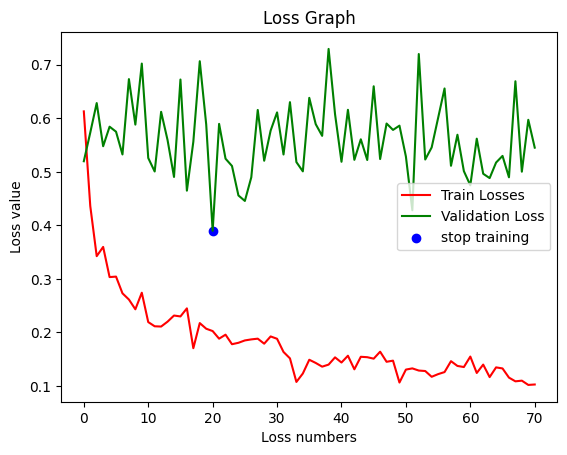

In [27]:
train_losses_number = list(range(len(train_losses)))
validation_losses_numbers = list(range(len(validation_losses)))

plt.plot(train_losses_number, train_losses, label='Train Losses', color='red')

# plot validation
plt.plot(validation_losses_numbers, validation_losses, label='Validation Loss', color='green')

plt.scatter([validation_losses.index(min(validation_losses))], validation_losses[validation_losses.index(min(validation_losses))], label="stop training" ,color="Blue",)

plt.xlabel('Loss numbers')
plt.ylabel('Loss value')
plt.title('Loss Graph')
plt.legend()

plt.show()

# Part 6
#### Saving model

In [28]:
# find Best epoch

print("Minimum Index position: ",validation_losses.index(min(validation_losses))+1,":",validation_losses[validation_losses.index(min(validation_losses))])

Minimum Index position:  21 : 0.3898584246635437


In [29]:
# saving the model
torch.save(model.state_dict(), 'model_1.pt')

In [30]:
# Load the saved weights
model = SiameseModel()
model.load_state_dict(torch.load('model_1.pt'))
model.to(device)

SiameseModel(
  (conv1): Conv2d(3, 16, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4)

In [ ]:
import shutil
shutil.copy2('model_1.pt', '/content/drive/MyDrive/Weights/Finger Print ML-Dataset/model_1.pt')

# Part 7
#### Test model

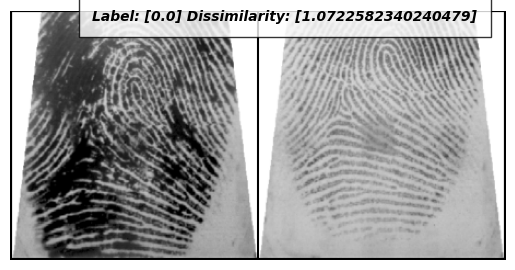

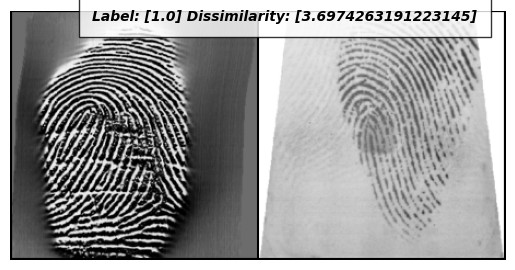

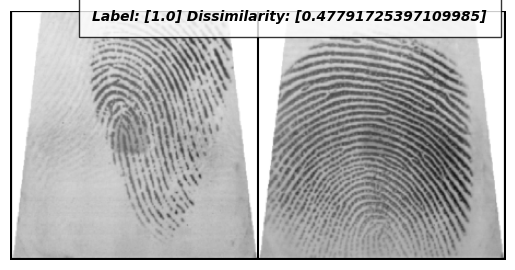

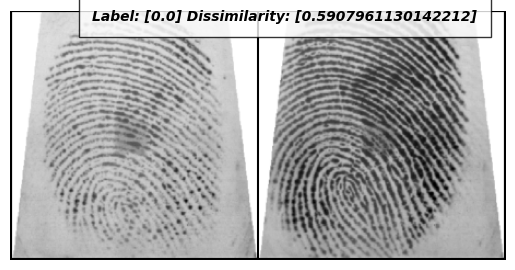

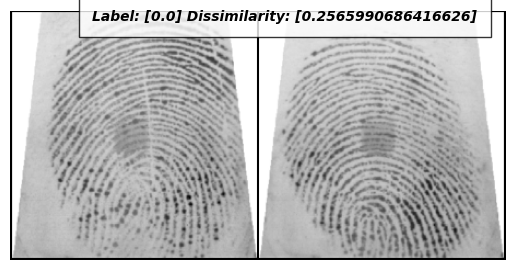

In [31]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="Finger Print ML-Dataset/test/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)

for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    x0, x1, label = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = model(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Label: {label.tolist()[0]} Dissimilarity: {euclidean_distance.tolist()}')

In [ ]:
# Load and preprocess two images
image_path1 = '105_7.tif'
image_path2 = '103_8.tif'

img1 = transformation(Image.open(image_path1).convert("L")).unsqueeze(0)
img2 = transformation(Image.open(image_path2).convert("L")).unsqueeze(0)

# Calculate the distance
with torch.no_grad():
    img1, img2 = img1.to(device), img2.to(device)
    output1, output2 = model(img1, img2)

    # Calculate the Euclidean distance
    euclidean_distance = F.pairwise_distance(output1, output2)

# Print the calculated distance
print(f"The Euclidean distance between the two images is: {euclidean_distance.item()}")